# peerBERT Trainer Notebook 

The following are the libraries we need to install, assuming that we started from a default Python Jupyter Notebook.
Comment them out once you have installed them the first time. User-managed notebooks are persistent and do not require installing libraries every run.

In [ ]:
# !pip install transformers --upgrade
# !pip install datasets --upgrade
# !pip install torch --upgrade
# !pip install openpyxl --upgrade
# !pip install accelerate --upgrade
# !pip install 'ray[tune]'
# !pip install tensorboard
# !pip install cloudml-hypertune

# !pip list

We start by importing the required libraries and then setting up our classes and functions.

In [11]:
import pandas as pd
import numpy as np
import os
import logging
import argparse

from sklearn.model_selection import train_test_split

from google.cloud import storage

from datasets import load_metric, Metric
from transformers import (RobertaConfig, RobertaTokenizer, RobertaForSequenceClassification,
                        TrainerCallback, EarlyStoppingCallback, TrainingArguments, Trainer)
import torch
from torch.utils.data import Dataset, DataLoader, SequentialSampler
import hypertune
from sklearn.metrics import hamming_loss, confusion_matrix, ConfusionMatrixDisplay, f1_score, matthews_corrcoef
import matplotlib.pyplot as plt

# Use for debugging to ger verbose messages if something goes wrong on a CUDA level
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

logging.basicConfig(
    format='%(asctime)s %(levelname)-4s [%(filename)s:%(lineno)d] - %(message)s',
    datefmt='%Y-%m-%dT%H:%M:%S%z',
    level=logging.INFO
)


# --------------------------------------------------------------------------------------
# The config Class contains all the information needed for running the Trainer, it can be also confifured using command line arguments.
# Command line arguments do not work in Jupyter notebooks, so they're ignored in the notebook.
class Config:
    def __init__(self):
        self.logLevel = logging.INFO
        self.vocabularySize: int = 50265
        self.hiddenLayers: int = 6
        self.tierLevel: int = 1
        self.batchSize: int = 16
        self.metricType: str = 'matthews_correlation'
        self.numEpochs: int = 25
        self.earlyStopping: int = 3
        self.hpTune: bool = True
        
        self.tokenizerBucketName: str = 'mpr-research-tokenizers'
        self.modelBucketName: str = 'mpr-research-models'
        self.dataBucketName: str = 'mwrite-data-bucket-1'
        
        self.tempDownloadFolder: str = './tmp'
        if not os.path.exists(self.tempDownloadFolder):
            os.makedirs(self.tempDownloadFolder)
            
        self.problemTypeDict = {1:'single_label_classification' ,2:'multi_label_classification' }

        self.labelTierDict = {1:['Verification/Summary', 'Praise', 'Problem/Solution'],
                              2:['Writing/Formatting \nIssues', 'Missing Content', 'Incorrect Content']}

        self.savedModelsFolderDict = {1:'Tier 1 Models', 2:'Tier 2 Models'}

        self.trainLinkDict = {1:'Tier 1 Data.xlsx', 2:'Tier 2 Data.xlsx'}

        self.metricTypeDict = {1:load_metric('matthews_correlation'), 2:None}

        self.LRDict = {1:2e-5 , 2:2e-5}

        self.coreColumns = ['AuthorID','ReviewerID','Criterion','Course','Comment']
        self.tierColumsDict = {1:['CommentCode'], 2:['WritingFormatting', 'MissingContent', 'Incorrect']}

        self.client = storage.Client()
        
        self.robertaTokenizer = None
        self.robertaModel = None
        self.modelName = None
        self.computeMetrics = None
        
        self.testMode = False
        
    
    def setUpFromArgs(self):
        parserNamespace = setUpParser()
        self.logLevel = parserNamespace.logging_level
        self.vocabularySize = parserNamespace.vocabulary_size
        self.hiddenLayers = parserNamespace.hidden_layers
        self.tierLevel = parserNamespace.tier_level
        self.batchSize = parserNamespace.batch_size
        self.metricType = parserNamespace.metric_type
        self.numEpochs = parserNamespace.num_epochs
        self.earlyStopping = parserNamespace.early_stopping
        self.hpTune = parserNamespace.hp_tune
        
        self.tokenizerBucketName = parserNamespace.tokenizer_bucket
        self.modelBucketName = parserNamespace.model_bucket
        self.dataBucketName = parserNamespace.data_bucket
        
            
    def loadTokenizer(self):
        tokenizerBucket = self.client.get_bucket(self.tokenizerBucketName)

        for file in tokenizerBucket.list_blobs(prefix=str(self.vocabularySize)):
            if not os.path.exists(os.path.join(self.tempDownloadFolder,str(self.vocabularySize))):
                os.makedirs(os.path.join(self.tempDownloadFolder,str(self.vocabularySize)))
            if not os.path.exists(os.path.join(self.tempDownloadFolder,file.name)):
                file.download_to_filename(os.path.join(self.tempDownloadFolder,file.name))

        self.robertaTokenizer = RobertaTokenizer.from_pretrained(os.path.join(self.tempDownloadFolder,str(self.vocabularySize)), do_lower_case=True)
        

    def loadModel(self):
        if self.hiddenLayers > -1:
            robertaConfig = RobertaConfig(
                                        num_labels = 3,
                                        vocab_size=self.vocabularySize,  
                                        max_position_embeddings=514, 
                                        hidden_size=768,
                                        num_attention_heads=8, 
                                        num_hidden_layers=self.hiddenLayers, 
                                        type_vocab_size=1,
                                        problem_type=self.problemTypeDict[self.tierLevel],
                                        )

            self.robertaModel = RobertaForSequenceClassification(robertaConfig)
            self.modelName = 'Model_'+str(self.hiddenLayers)+'_Layers_'+str(self.tierLevel)+'_Tier_'+str(self.vocabularySize)
            
        else:
            self.robertaModel = RobertaForSequenceClassification.from_pretrained(
                                                                        'roberta-base',
                                                                        num_labels = 3,
                                                                        output_attentions = False,
                                                                        output_hidden_states = False,
                                                                        vocab_size = self.vocabularySize,
                                                                        problem_type=self.problemTypeDict[self.tierLevel],
                                                                        )
            
            self.modelName = 'Model_roberta-base_'+str(self.tierLevel)+'_Tier_'+str(self.vocabularySize)
            
        if self.testMode:
            self.modelName = 'test'+self.modelName
            
    def loadModelFromFile(self):
        if self.hiddenLayers > -1:
            self.modelName = 'Model_'+str(self.hiddenLayers)+'_Layers_'+str(self.tierLevel)+'_Tier_'+str(self.vocabularySize)
        else:
            self.modelName = 'Model_roberta-base_'+str(self.tierLevel)+'_Tier_'+str(self.vocabularySize)
        if self.testMode:
            self.modelName = 'test'+self.modelName
            
        self.robertaModel = RobertaForSequenceClassification.from_pretrained(os.path.join(self.tempDownloadFolder,self.modelName))
        
    def setMetrics(self):
        return self.metricTypeDict[self.tierLevel]     
    
    
class HPTuneCallback(TrainerCallback):
    """
    A custom callback class that reports a metric to hypertuner
    at the end of each epoch.
    """
    def __init__(self, metric_tag, metric_value):
        super(HPTuneCallback, self).__init__()
        self.metric_tag = metric_tag
        self.metric_value = metric_value
        self.hpt = hypertune.HyperTune()

    def on_evaluate(self, args, state, control, **kwargs):
        logging.info(f"HP metric {self.metric_tag}={kwargs['metrics'][self.metric_value]}")
        self.hpt.report_hyperparameter_tuning_metric(
            hyperparameter_metric_tag=self.metric_tag,
            metric_value=kwargs['metrics'][self.metric_value],
            global_step=state.epoch)

    
class peerDataset(Dataset):
    def __init__(self, df, config):
        self.config = config
        self.comments = df['Comment'].values 
        if self.config.tierLevel == 1:
            self.labels = torch.tensor(df[self.config.tierColumsDict[self.config.tierLevel]].values,dtype=torch.long)
        if self.config.tierLevel == 2:
            self.labels = torch.tensor(df[self.config.tierColumsDict[self.config.tierLevel]].values,dtype=torch.float)

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        self.tokenizedData = sentenceTokenizer(self.comments[idx], self.config.robertaTokenizer)
        self.tokenizedData['labels'] = self.labels[idx]
        return self.tokenizedData
    
#--------------------------------------------------------------------------------------


def setUpParser():
    parser = argparse.ArgumentParser(description='Take in command line arguments.')
    parser.add_argument(
        '--tier-level',
        help='Tier level for classification problem. Defaults to 1.',
        choices=[1,2],
        default=1,
        type=int)
    parser.add_argument(
        '--vocabulary-size',
        help='Vocabulary size for Roberta Tokenizer and Models. Defaults to 50265.',
        choices=[50265,30522],
        default=50265,
        type=int)
    parser.add_argument(
        '--hidden-layers',
        help='Number of hidden layers to use if building a model from Roverta Config is used. Set to -1 to use roberta-base instead. Defaults to 6.',
        default=6,
        type=int)
    parser.add_argument(
        '--batch-size',
        help='Batch size for data fed to the model. Defaults to 16. Warning, higher batch sizes need higher memory requirements, make sure your job is configured appropiately.',
        default=16,
        type=int)
    parser.add_argument(
        '--num-epochs',
        help='Number of training epochs to run for. Defaults to 100.',
        default=100,
        type=int)
    parser.add_argument(
        '--learning-rate',
        help='Learning rate value for the optimizers. Defaults to 2e-5.',
        default=2e-5,
        type=float)
    parser.add_argument(
        '--metric-type',
        help='The metric used in training and validation. Defaults to "matthews-correlation". Currently the only one implemented.',
        choices=['matthews-correlation'],
        default='matthews-correlation',
        type=str)
    parser.add_argument(
        '--tokenizer-bucket',
        help='GCP bucket where tokenizer files are stored. Defaults to "mpr-research-tokenizers".',
        default='mpr-research-tokenizers',
        type=str)
    parser.add_argument(
        '--model-bucket',
        help='GCP bucket where model files are uploaded after training. Defaults to "mpr-research-data".',
        default='mpr-research-models',
        type=str)
    parser.add_argument(
        '--data-bucket',
        help='GCP bucket where training files are stored. Defaults to "mwrite-data-bucket-1".',
        default='mwrite-data-bucket-1',
        type=str)
    parser.add_argument(
        '--seed',
        help='Random seed for splitting data. Defaults to 5222.',
        default=5222,
        type=int)
    parser.add_argument(
        '--logging-level',
        help='Set default Logging Level. Defaults to INFO.',
        choices=['DEBUG', 'INFO', 'WARNING', 'ERROR', 'FATAL'],
        default='INFO',
        type=str)

    # Enable hyperparameters
    parser.add_argument(
        '--early-stopping',
        help='Patience for early stopping. Defaults to 3. Set to -1 to disable early stopping.',
        default=3,
        type=int)
    parser.add_argument(
        '--hp-tune',
        help='Enable hyperparameter tuning. Defaults to "y".',
        choices=['y','n'],
        default='y',
        type=str)
    parser.add_argument(
        '--job-dir',
        help='GCS location to export models',
        default=os.getenv('AIP_MODEL_DIR'),
        type=str)
    
    return parser.parse_args()


def sentenceTokenizer(sentence, tokenizer):
    tokenizedSentence = tokenizer(sentence, add_special_tokens = True, 
                                  max_length= 512, truncation='longest_first', padding='max_length', 
                                  return_attention_mask=True, return_tensors='pt')
    tokenizedSentence = {key:tokenizedSentence[key][0] for key in tokenizedSentence}
    return tokenizedSentence


def DFToDatasetMaker(config):
    df = pd.read_excel('gs://'+os.path.join(config.dataBucketName, config.trainLinkDict[config.tierLevel]))
    df = df[config.coreColumns+config.tierColumsDict[config.tierLevel]].dropna()

    if config.tierLevel == 1:
        trainDF, testDF = train_test_split(df, test_size=0.2, stratify=df[config.tierColumsDict[config.tierLevel]], random_state=5222)
        trainDF, valDF = train_test_split(trainDF, test_size=0.25, stratify=trainDF[config.tierColumsDict[config.tierLevel]], random_state=5222)
    if config.tierLevel == 2:
        dfLow = df[df['MissingContent']==0]
        dfHigh = df[(df['MissingContent']==1) & (df['WritingFormatting']==0) & (df['Incorrect']==0)].sample(900)
        dfNew = dfHigh.append(dfLow)
        trainDF, testDF = train_test_split(dfNew, test_size=0.2, stratify=dfNew[config.tierColumsDict[config.tierLevel]], random_state=5222)
        trainDF, valDF = train_test_split(trainDF, test_size=0.25, stratify=trainDF[config.tierColumsDict[config.tierLevel]], random_state=5222)

    DFDict = {'train':trainDF, 'test':testDF, 'val':valDF}

    dataLoaderDict = {splitType: peerDataset(DFDict[splitType], config) for splitType in DFDict}
    
    return dataLoaderDict


def computeMetricsTier1(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

def computeMetricsTier2(eval_pred):
    logits, labels = eval_pred
    predictions = np.where(logits > 0, 1, 0)
    adjustFactor = 0.5
    mccWeighted = 0.
    for index in [0,1,2]:
        mccScore = matthews_corrcoef(labels[:,index], np.where(predictions[:,index] > 0, 1, 0))
        print(index, mccScore)
        mccWeighted += mccScore*(adjustFactor+index)/(3+3*adjustFactor)
    return {'Weighted MCC': mccWeighted}
    #return {'Hamming Score': 1-hamming_loss(labels, predictions)}

computeMetricsDict = {1: computeMetricsTier1,2: computeMetricsTier2}


def makeTrainingArgs(config):
    return TrainingArguments(
                            output_dir=os.path.join(config.tempDownloadFolder,'trainerTier'+str(config.tierLevel)+'Logs'),
                            evaluation_strategy='steps',
                            logging_steps=100,
                            learning_rate=config.LRDict[config.tierLevel],
                            per_device_train_batch_size=config.batchSize,
                            per_device_eval_batch_size=config.batchSize,
                            #auto_find_batch_size = True,
                            num_train_epochs=config.numEpochs,
                            #label_names=labelTierDict[tierLevel],
                            metric_for_best_model = 'eval_loss',
                            load_best_model_at_end = True,
                            greater_is_better = False
                            )


def trainerBuilder(config, dataLoaderDict):
    trainingArgs = makeTrainingArgs(config)

    trainer = Trainer(
                    model=config.robertaModel,
                    args=trainingArgs,
                    train_dataset=dataLoaderDict['train'],
                    eval_dataset=dataLoaderDict['val'],
                    compute_metrics=computeMetricsDict[config.tierLevel],
                    )
    
    if config.earlyStopping > -1:
        trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=config.earlyStopping))
    if config.hpTune:
        trainer.add_callback(HPTuneCallback("loss", "eval_loss"))
    
    return trainer


def getMetrics(testDataLoader, loadedTrainer, config, printMode=False):
    predsDict = loadedTrainer.predict(testDataLoader)

    truthList = np.array(predsDict.label_ids)

    if config.tierLevel == 1:
        predList = np.argmax(predsDict.predictions, axis=-1)
    if config.tierLevel == 2:
        predList = np.where(predsDict.predictions > 0, 1, 0)

    if printMode:
        logging.info(f"Macro F1-Score:{f1_score(truthList, predList, average='macro')}")

        if config.tierLevel == 2:
            for index,label in enumerate(config.labelTierDict[config.tierLevel]):
                logging.info(f'Target Label: {label}')
                logging.info(f'MCC: {matthews_corrcoef(truthList[:,index], np.where(predsDict.predictions[:,index] > 0, 1, 0))}')
        
    return truthList, predList


def labelListMaker(dataList, config, index=None):
    if config.tierLevel == 1:
        return [config.labelTierDict[config.tierLevel][int(value)] for value in dataList]
    if config.tierLevel == 2:
        labelList = ['No '+config.labelTierDict[config.tierLevel][index], config.labelTierDict[config.tierLevel][index]]
        return [labelList[int(value)] for value in dataList]
            
    
def savedModelMetricsViewer(config, dataLoaderDict=None, splitType='test', printMode=False):
    
    if not dataLoaderDict:
        dataLoaderDict = DFToDatasetMaker(config)
        
    loadedModel = config.robertaModel

    loadedTrainer = trainerBuilder(config, dataLoaderDict)

    truthList, predList = getMetrics(dataLoaderDict[splitType], loadedTrainer, config, printMode)

    if config.tierLevel == 1:
        convertedTruthList = labelListMaker(truthList, config)
        convertedPredList = labelListMaker(predList, config)

        cm = confusion_matrix(convertedTruthList, convertedPredList, labels=config.labelTierDict[config.tierLevel])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=config.labelTierDict[config.tierLevel])
        disp.plot()
        plt.show()

    if config.tierLevel == 2:
        for index,label in enumerate(config.labelTierDict[config.tierLevel]):
            convertedTruthList = labelListMaker(truthList[:,index], config, index)
            convertedPredList = labelListMaker(predList[:,index], config, index) 

            labelList = ['No '+config.labelTierDict[config.tierLevel][index], config.labelTierDict[config.tierLevel][index]]
            print('Target Label:', label)
            cm = confusion_matrix(convertedTruthList, convertedPredList, labels=labelList)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labelList)
            disp.plot()
            plt.show()


def saveModelToGCS(config):
    try:
        modelBucket = config.client.bucket(config.modelBucketName)
        localModelPath = os.path.join(config.tempDownloadFolder, config.modelName)
        files = [f for f in os.listdir(localModelPath) if os.path.isfile(os.path.join(localModelPath, f))]

        for file in files:
            localFile = os.path.join(localModelPath, file)
            blob = modelBucket.blob("/".join([config.modelName, file]))
            blob.upload_from_filename(localFile)
        logging.info(f'Saved model files in gs://{config.modelBucketName}/{config.modelName}')

    except Exception as e:
        logging.error(f'Error: {e}')
        logging.error(f'Saved model files instead locally at {os.path.join(config.tempDownloadFolder, config.modelName)}.')
        

def saveAndUploadModel(trainer, config, cloudSave=True):
    
    trainer.save_model(os.path.join(config.tempDownloadFolder, config.modelName))
    
    if cloudSave:
        saveModelToGCS(config)
    
    return True
        

When training in Jupyter, adjust config parameters here before loading in the tokenizer and model.
The main one is the tierLevel, which switches which tier level of classification the model is to be trained on
The number of hiddern layer lets you make a custom model, set to -1 to use the roberta-base one. 
testMode just appends 'test' to the start of the saved files. Use it when you are debugging.

Simply put, for two levels of classifcation, you need to run the code block twice, adjusting the tierLevel variable for it.

In [16]:
configTrain = Config()
configTrain.tierLevel = 1
configTrain.hiddenLayers = -1
configTrain.testMode = False

configTrain.loadTokenizer()
configTrain.loadModel()
global metric
metric = configTrain.setMetrics()    

logging.info('Loaded in config for job.')

dataLoaderDict = DFToDatasetMaker(configTrain)

logging.info('Retrieved and set up data batching pipeline.')

trainer = trainerBuilder(configTrain, dataLoaderDict)

logging.info('Trainer set up.')

trainer.train()

logging.info('Training complete.')

metrics = trainer.evaluate(eval_dataset=dataLoaderDict['test'])
trainer.save_metrics("all", metrics)

logging.info('Saving model to GCP.')

saveAndUploadModel(trainer, configTrain, True)

# Set to False if you do not want to push the model to the GCP bucket. Useful during debugging and testing.

Didn't find file ./tmp/50265/added_tokens.json. We won't load it.
Didn't find file ./tmp/50265/special_tokens_map.json. We won't load it.
Didn't find file ./tmp/50265/tokenizer_config.json. We won't load it.
loading file ./tmp/50265/vocab.json
loading file ./tmp/50265/merges.txt
loading file None
loading file None
loading file None
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /home/jupyter/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermedi

Step,Training Loss,Validation Loss,Matthews Correlation
100,0.744400,0.684670,0.408544
200,0.689700,0.612098,0.523195
300,0.571100,0.494735,0.612917
400,0.508500,0.475926,0.666784
500,0.418000,0.451936,0.672073
600,0.389500,0.492686,0.694606
700,0.420000,0.503348,0.664399
800,0.325000,0.515284,0.693800


***** Running Evaluation *****
  Num examples = 1248
  Batch size = 16
2022-06-19T00:48:16+0000 INFO [3592687769.py:163] - HP metric loss=0.6846699118614197
***** Running Evaluation *****
  Num examples = 1248
  Batch size = 16
2022-06-19T00:49:24+0000 INFO [3592687769.py:163] - HP metric loss=0.6120984554290771
***** Running Evaluation *****
  Num examples = 1248
  Batch size = 16
2022-06-19T00:50:31+0000 INFO [3592687769.py:163] - HP metric loss=0.49473464488983154
***** Running Evaluation *****
  Num examples = 1248
  Batch size = 16
2022-06-19T00:51:39+0000 INFO [3592687769.py:163] - HP metric loss=0.4759259819984436
***** Running Evaluation *****
  Num examples = 1248
  Batch size = 16
2022-06-19T00:52:47+0000 INFO [3592687769.py:163] - HP metric loss=0.4519355595111847
Saving model checkpoint to ./tmp/trainerTier1Logs/checkpoint-500
Configuration saved in ./tmp/trainerTier1Logs/checkpoint-500/config.json
Model weights saved in ./tmp/trainerTier1Logs/checkpoint-500/pytorch_model.b

2022-06-19T00:56:37+0000 INFO [3592687769.py:163] - HP metric loss=0.47335943579673767
2022-06-19T00:56:38+0000 INFO [2487603472.py:28] - Saving model to GCP.
Saving model checkpoint to ./tmp/Model_roberta-base_1_Tier_50265
Configuration saved in ./tmp/Model_roberta-base_1_Tier_50265/config.json
Model weights saved in ./tmp/Model_roberta-base_1_Tier_50265/pytorch_model.bin


True

This is for testing your models after training. tierLevel, hiddenLayers and testMode should let you uniquely idetify any model trained, or saved to file if present. 

Didn't find file ./tmp/50265/added_tokens.json. We won't load it.
Didn't find file ./tmp/50265/special_tokens_map.json. We won't load it.
Didn't find file ./tmp/50265/tokenizer_config.json. We won't load it.
loading file ./tmp/50265/vocab.json
loading file ./tmp/50265/merges.txt
loading file None
loading file None
loading file None
loading configuration file ./tmp/Model_roberta-base_1_Tier_50265/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,


2022-06-19T01:00:22+0000 INFO [3592687769.py:374] - Macro F1-Score:0.7733893204603772


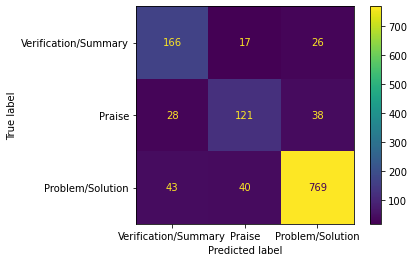

In [19]:
configTest = Config()
configTest.tierLevel = 1
configTest.hiddenLayers = -1
configTest.testMode = False

configTest.loadTokenizer()
configTest.loadModelFromFile()

savedModelMetricsViewer(configTest,splitType='test',printMode=True)
# Set splitmode to train to see training metrics. printMode gives a slightly more verbose output of the metrics.